In [1]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.image as mpimg
import sklearn
from keras import optimizers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense , Activation , Dropout ,Flatten,  MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import confusion_matrix 
from scipy.spatial.distance import cdist
from skimage.measure import label, regionprops, moments, moments_central, moments_normalized, moments_hu
from skimage.transform import rescale, resize, downscale_local_mean
from skimage import io, exposure, feature
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle 
import pickle
import cv2
import os
plt.rcParams["figure.figsize"] = (20,3)

In [2]:
def face_detection(img):
    # Read image from your local file system
    original_image = img
    grayscale_image = original_image
    # Convert color image to grayscale for Viola-Jones
#     grayscale_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    # Load the classifier and create a cascade object for face detection
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_alt.xml')
    detected_faces = face_cascade.detectMultiScale(grayscale_image)
    for (column, row, width, height) in detected_faces:
        cv2.rectangle(
            original_image,
            (column, row),
            (column + width, row + height),
            (0, 255, 0),
            2
        )
        sub_face = img[row:row+height, column:column+width]
        sub_face = sub_face[2:sub_face.shape[1]-1, 2:sub_face.shape[1]-1]
    return sub_face

#https://docs.opencv.org/master/d4/d13/tutorial_py_filtering.html
def smoothing(img, d=5, sigmaColor=65, sigmaSpace=65):
    blur_img = cv2.bilateralFilter(img,d,sigmaColor,sigmaSpace)
    return blur_img

#https://docs.opencv.org/3.4/d4/d1b/tutorial_histogram_equalization.html
def histogram_equalization(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    dst = cv2.equalizeHist(img)
    return dst

In [3]:
# get one image function and resize
def get_image(emotion_folders, emotion, img,is_filter=False, filters=None, log_it=False, detect_face=False):
    input_img=cv2.imread(emotion_folders + '/'+ emotion + '/'+ img )
    #input_img = face_detection(input_img)
    if is_filter and filters == '1':
        input_img = smoothing(input_img)
    elif is_filter and filters == '2':
        input_img = face_detection(input_img)
    elif is_filter and filters == '3':
        input_img = histogram_equalization(input_img)
    elif detect_face:
        input_img = face_detection(input_img)
    input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
    input_img_resize=cv2.resize(input_img,(48,48))
    input_img_resize = input_img_resize/255.0
#     if log_it:
#         print ('Loaded image for emotion: '+str(emotion))
    return input_img_resize

# get one image function and resize
def get_all_images(path, all_emotions_folders,is_filter=False, filters=None, log_it=False):
    emotions_list = os.listdir(path)
    indicies = []
    
    emos = []
    num_emos = []
    img_labels = []
    img_all_data=[]
    log_it=True
    for emotion in emotions_list:
        if emotion !='.DS_Store' and emotion !='contempt':
            img_list=os.listdir(path+'/'+ emotion) 
            emos.append(emotion)
            num_emos.append(len(img_list))
            print ('Loaded images for emotion: '+str(emotion)+', number of emotions: '+str(len(img_list)))
            for img in img_list:
                if img !='.ipynb_checkpoints':
                    input_img_resize=get_image(path, emotion,img, is_filter, filters, log_it)
                    if log_it:
                        indicies.append(len(img_all_data))
                    img_all_data.append(input_img_resize)
                    img_labels.append(emotion)
                    log_it=False
            log_it=True
    img_data = np.array(img_all_data)
    img_labels = np.array(img_labels)
    # why to divide by 255 The reason is that if the color intensity is a float
    #, then matplotlib expects it to range from 0 to 1. If an int, 
    #then it expects 0 to 255. So you can either force all the numbers to int or scale them all by 1/255.
    #https://stackoverflow.com/questions/49643907/clipping-input-data-to-the-valid-range-for-imshow-with-rgb-data-0-1-for-floa
    img_data = img_data.astype('float32')
    return img_data, img_labels, indicies
def standarize(data_list):
    stand = []
    for i in data_list:
        standi = (i-i.mean())/i.std()
        stand.append(standi)
    return np.array(stand).astype('float32')

In [4]:
emotions_map = {'happy':0,'fear':1,'surprise':2,'sadness':3,'anger':4,'disgust':5}

In [5]:
kdef_emotions_map={'HA':0,'AF':1,'SU':2,'SA':3,'AN':4,'DI':5}
def get_image(emotion_folders, emotion, img,is_filter=False, filters=None, log_it=False, detect_face=False):
    input_img=cv2.imread(emotion_folders + '/'+ emotion + '/'+ img )
    input_img = face_detection(input_img)
    if is_filter and filters == '1':
        input_img = smoothing(input_img)
    elif is_filter and filters == '2':
        input_img = face_detection(input_img)
    elif is_filter and filters == '3':
        input_img = histogram_equalization(input_img)
    elif detect_face:
        input_img = face_detection(input_img)
    input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
    input_img_resize=cv2.resize(input_img,(48,48))
    input_img_resize = input_img_resize/255.0
#     if log_it:
#         print ('Loaded image for emotion: '+str(emotion))
    return input_img_resize
def load_kdef_dataset(path, is_filter=True, filters='1', log_it=False):
    all_folders = os.listdir(path)
    img_labels = []
    img_all_data=[]
    log_it=True
    for folder in all_folders:
        if folder !='.DS_Store':
            img_list=os.listdir(path+'/'+ folder) 
            for img in img_list:
                if img[6] == 'S' and img[4:6]!='NE' :
                    input_img_resize=get_image(path, folder,img, is_filter=is_filter, filters=filters, log_it=log_it,detect_face= True)
                    img_all_data.append(input_img_resize)
                    img_labels.append(kdef_emotions_map[img[4:6]])
    img_data = np.array(img_all_data)
    img_labels = np.array(img_labels)
    img_data = img_data.astype('float32')
    return img_data, img_labels
#img_data, img_labels = load_kdef_dataset('./KDEF/')

In [6]:
#num_points = 8 * radius
#https://www.pyimagesearch.com/2015/12/07/local-binary-patterns-with-python-opencv/
def LBP_features(img, numPoints, radius):
    gray = img
    f =feature.local_binary_pattern(gray, P=numPoints, R=radius, method="uniform")[:, :, None] 
    return f
def get_LBP_features(img_data):
    features = []
    for img in img_data:
        img_feature = LBP_features(img, 24, 3)
        features.append(img_feature)
    return np.array(features)

In [7]:
ck_path = './archive/CK+48'
all_emotions_folders = os.listdir(ck_path)
if '.DS_Store' in all_emotions_folders: all_emotions_folders.remove('.DS_Store')
smoothed_imgs, labels,indices = get_all_images(ck_path, all_emotions_folders, is_filter=True, filters='1', log_it=True)
imgs_features = get_LBP_features(smoothed_imgs)
standarize_features = standarize(imgs_features)
import tensorflow.keras.utils as utils
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
print(set(labels_encoded))
labels_final = utils.to_categorical(labels_encoded, 6)
features_shuffled, labels_shuffled = sklearn.utils.shuffle(standarize_features, labels_final)

Loaded images for emotion: happy, number of emotions: 208
Loaded images for emotion: fear, number of emotions: 76
Loaded images for emotion: surprise, number of emotions: 250
Loaded images for emotion: sadness, number of emotions: 84
Loaded images for emotion: anger, number of emotions: 136
Loaded images for emotion: disgust, number of emotions: 177
{0, 1, 2, 3, 4, 5}


In [8]:
test_img_data, test_img_labels = load_kdef_dataset('./KDEF/', is_filter=True, filters='1', log_it=False)
imgs_features_2 = get_LBP_features(test_img_data)
standarize_features_2 = standarize(imgs_features_2)
import tensorflow.keras.utils as utils
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(test_img_labels)
print(set(labels_encoded))
labels_final_2 = utils.to_categorical(labels_encoded, 6)
features_shuffled_2, labels_shuffled_2 = sklearn.utils.shuffle(standarize_features_2, labels_final_2)

{0, 1, 2, 3, 4, 5}


In [9]:
features_shuffled.shape

(927, 48, 48, 1)

In [10]:
all_data = np.concatenate((features_shuffled, features_shuffled_2), axis=0)
all_labels =  np.concatenate((labels_shuffled, labels_shuffled_2), axis=0)
#all_data,all_labels= sklearn.utils.shuffle(all_data, all_labels)

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features_shuffled, labels_shuffled, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [12]:
def create_model(optim):
    input_shape=(48,48,1)
    model = Sequential()
    model.add(Conv2D(64, (5, 5), input_shape=input_shape, padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))    
    model.add(Conv2D(128, (5, 5), padding='same')) 
    model.add(MaxPooling2D(pool_size=(2, 2)))    
    model.add(Conv2D(256, (5, 5), padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Dropout(0.25))
    model.add(Dense(500))
    model.add(Dense(6, activation = 'softmax'))

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=optim)
    
    return model

In [18]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.95)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
model = create_model(optimizer)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 48, 48, 64)        1664      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 12, 256)       819456    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 256)         0         
_________________________________________________________________
activation_1 (Activation)    (None, 6, 6, 256)        

In [19]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

checkpoint_path = "cross/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
history = model.fit(x=X_train, y= y_train, validation_data=(X_val, y_val), batch_size=32, 
          epochs=50, callbacks=[cp_callback, early_stopping])

Train on 592 samples, validate on 149 samples
Epoch 1/50
576/592 [============================>.] - ETA: 0s - loss: 1.6294 - accuracy: 0.3490
Epoch 00001: saving model to cross/cp.ckpt
592/592 [==============================] - 11s 19ms/sample - loss: 1.6135 - accuracy: 0.3581 - val_loss: 1.5154 - val_accuracy: 0.4698
Epoch 2/50
576/592 [============================>.] - ETA: 0s - loss: 1.1959 - accuracy: 0.6267
Epoch 00002: saving model to cross/cp.ckpt
592/592 [==============================] - 13s 22ms/sample - loss: 1.1946 - accuracy: 0.6267 - val_loss: 1.2859 - val_accuracy: 0.5302
Epoch 3/50
576/592 [============================>.] - ETA: 0s - loss: 0.8185 - accuracy: 0.7604
Epoch 00003: saving model to cross/cp.ckpt
592/592 [==============================] - 14s 24ms/sample - loss: 0.8188 - accuracy: 0.7584 - val_loss: 0.7727 - val_accuracy: 0.7114
Epoch 4/50
576/592 [============================>.] - ETA: 0s - loss: 0.5660 - accuracy: 0.8333
Epoch 00004: saving model to cross/c

In [ ]:
plt.rcParams["figure.figsize"] = (10,7)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss and Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc','train_loss', 'val_loss'], loc='upper left')
# plt.show()

In [ ]:
loss, acc = model.evaluate(X_test, y_test, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))
predicted_results = model.predict_classes(X_test)

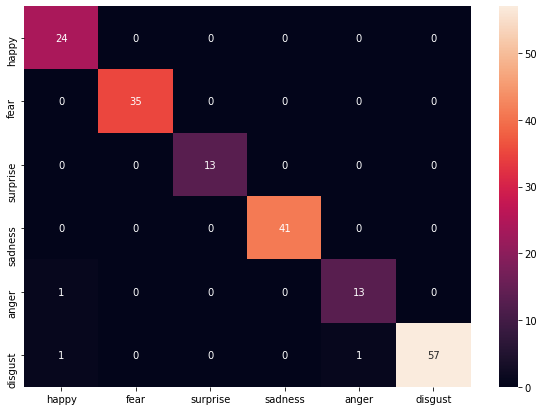

In [22]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
df_cm = pd.DataFrame(confusion_matrix(predicted_results,np.argmax(y_test, axis=-1) ), range(6), range(6))
# plt.figure(figsize=(10,7))
sn.heatmap(df_cm, annot=True, xticklabels=emotions_map.keys(), yticklabels=emotions_map.keys())# font size

plt.show()

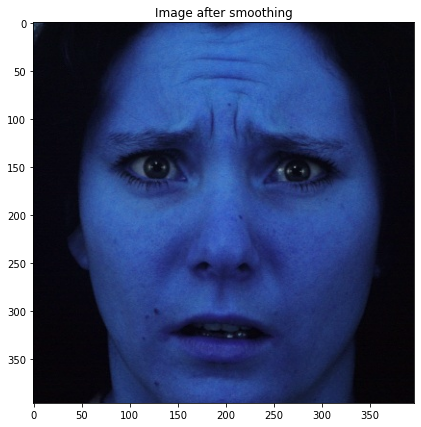

(48, 48)
[[0.0061387  0.10628878 0.73934263 0.00593375 0.11312877 0.02916741]]
[2]
0.6138695403933525
10.628877580165863
73.93426299095154
0.5933751817792654
11.312876641750336
2.9167411848902702
{'happy': 0, 'fear': 1, 'surprise': 2, 'sadness': 3, 'anger': 4, 'disgust': 5}


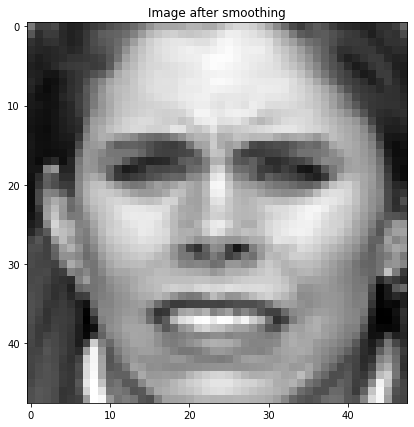

(48, 48)
[[1.5858088e-02 1.7551385e-04 1.5819883e-01 1.6092867e-04 7.7769021e-03
  8.1782973e-01]]
[5]
1.5858087688684464
0.017551385099068284
15.819883346557617
0.016092867008410394
0.7776902057230473
81.78297281265259
{'happy': 0, 'fear': 1, 'surprise': 2, 'sadness': 3, 'anger': 4, 'disgust': 5}


In [23]:
def get_emotion(image, detect_face):
    input_img=cv2.imread(image)
    if detect_face:
        input_img = face_detection(input_img)
    plt.imshow(input_img, cmap="gray") 
    plt.title('Image after smoothing') 
    io.show()
    input_img = smoothing(input_img)
    input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
    input_img_resize = cv2.resize(input_img,(48,48))
    input_img_resize = input_img_resize/255.0
    print(input_img_resize.shape)
    test_imgs_features =feature.local_binary_pattern(input_img_resize, P=25, R=5, method="uniform")[:, :, None]
    standarize_features = standarize(test_imgs_features)

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.95)
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
    model = create_model(optimizer)
    model.load_weights("cross/cp.ckpt")
    predicted_resultds = model.predict(np.array([standarize_features]))
    predicted_resultds1 = model.predict_classes(np.array([standarize_features]))
    print(predicted_resultds)
    print(predicted_resultds1)
    for i in predicted_resultds[0]:
        print(i*100)
    print(emotions_map)
get_emotion('KDEF/AF02/AF02AFS.JPG', detect_face=True)
get_emotion('archive/CK+48/fear/S032_004_00000012.png', detect_face=False)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
 
checkpoint_path = "cross/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
 
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
history=[]
accuracies=[]
losses=[]
predicted_results = []
from sklearn.model_selection import KFold
kf=KFold(n_splits=5, random_state=None, shuffle=False)
for train_index, test_index in kf.split(all_data):
    X_train, X_test = all_data[train_index], all_data[test_index]
    y_train, y_test = all_labels[train_index], all_labels[test_index]
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
    history.append(model.fit(x=X_train, y= y_train, validation_data=(X_val, y_val), batch_size=32, 
          epochs=10, callbacks=[cp_callback, early_stopping]))
    loss, acc = model.evaluate(X_test, y_test, verbose=2)
    losses.append(loss)
    accuracies.append(acc)
    print("Restored model, accuracy: {:5.2f}%".format(100 * acc))
    predicted_results.append(model.predict_classes(X_test))

In [109]:
(sum(accuracies)/len(accuracies))*100

96.38337969779968

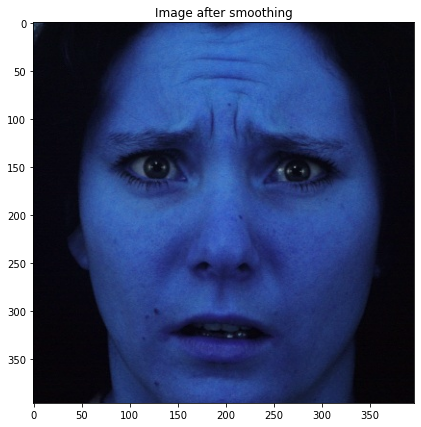

(48, 48)
[[3.3718153e-04 5.8310974e-01 8.7458402e-04 3.8741124e-01 2.0580450e-03
  2.6209125e-02]]
[1]
0.033718152553774416
58.31097364425659
0.08745840168558061
38.74112367630005
0.2058045007288456
2.620912529528141
{'happy': 0, 'fear': 1, 'surprise': 2, 'sadness': 3, 'anger': 4, 'disgust': 5}


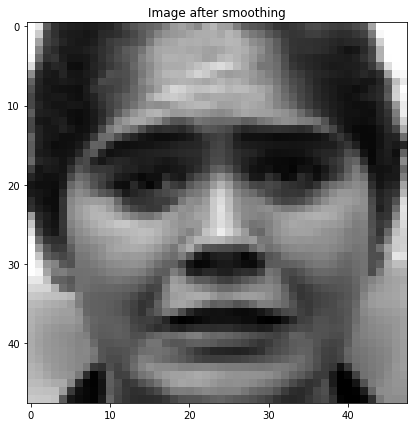

(48, 48)
[[0.2117704  0.0643414  0.01553702 0.0310706  0.06959119 0.60768944]]
[5]
21.17704004049301
6.434139609336853
1.55370207503438
3.107060492038727
6.959118694067001
60.76894402503967
{'happy': 0, 'fear': 1, 'surprise': 2, 'sadness': 3, 'anger': 4, 'disgust': 5}


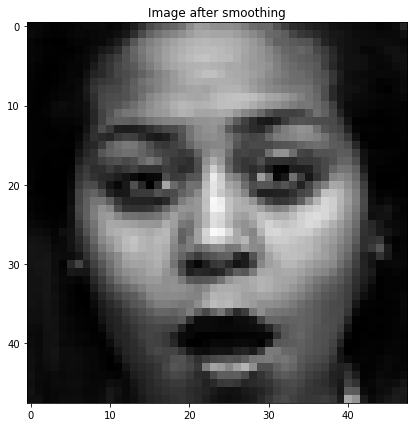

(48, 48)
[[4.1021884e-04 3.4206818e-04 5.1872873e-01 2.8855413e-05 1.5078500e-02
  4.6541154e-01]]
[2]
0.0410218839533627
0.03420681750867516
51.872873306274414
0.002885541289288085
1.5078499913215637
46.54115438461304
{'happy': 0, 'fear': 1, 'surprise': 2, 'sadness': 3, 'anger': 4, 'disgust': 5}


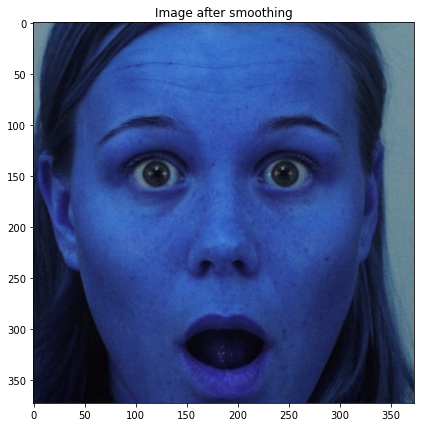

(48, 48)
[[7.7323214e-04 1.5607856e-01 7.7068025e-01 2.4529259e-06 4.2885896e-03
  6.8176813e-02]]
[2]
0.07732321391813457
15.607856214046478
77.06802487373352
0.0002452925855322974
0.4288589581847191
6.8176813423633575
{'happy': 0, 'fear': 1, 'surprise': 2, 'sadness': 3, 'anger': 4, 'disgust': 5}


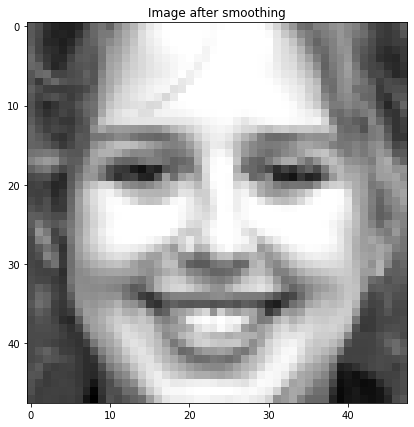

(48, 48)
[[8.8189793e-01 2.8992293e-02 7.0501410e-04 2.5595858e-05 8.7250497e-05
  8.8291846e-02]]
[0]
88.18979263305664
2.8992293402552605
0.07050140993669629
0.002559585846029222
0.008725049701752141
8.829184621572495
{'happy': 0, 'fear': 1, 'surprise': 2, 'sadness': 3, 'anger': 4, 'disgust': 5}


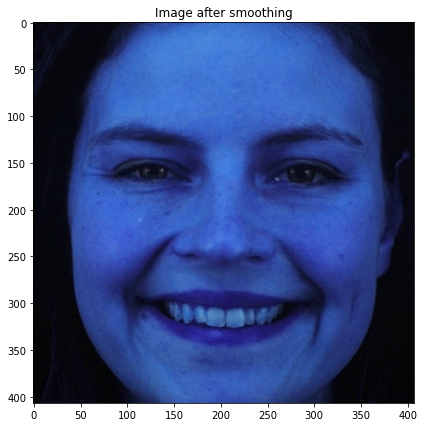

(48, 48)
[[8.9639837e-01 8.9488300e-03 4.9528107e-04 6.9421879e-04 1.0232742e-05
  9.3453005e-02]]
[0]
89.63983654975891
0.8948829956352711
0.049528107047080994
0.06942187901586294
0.001023274217004655
9.345300495624542
{'happy': 0, 'fear': 1, 'surprise': 2, 'sadness': 3, 'anger': 4, 'disgust': 5}


In [146]:
def get_emotion(model, image, detect_face):
    input_img=cv2.imread(image)
    if detect_face:
        input_img = face_detection(input_img)
    plt.imshow(input_img, cmap="gray") 
    plt.title('Image after smoothing') 
    io.show()
    input_img = smoothing(input_img)
    input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
    input_img_resize = cv2.resize(input_img,(48,48))
    input_img_resize = input_img_resize/255.0
    print(input_img_resize.shape)
    test_imgs_features =feature.local_binary_pattern(input_img_resize, P=25, R=5, method="uniform")[:, :, None]
    standarize_features = standarize(test_imgs_features)

#     lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-2,
#     decay_steps=10000,
#     decay_rate=0.95)
#     optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)
#     model = create_model(optimizer)
#     model.load_weights("cross/cp.ckpt")
    predicted_resultds = model.predict(np.array([standarize_features]))
    predicted_resultds1 = model.predict_classes(np.array([standarize_features]))
    print(predicted_resultds)
    print(predicted_resultds1)
    for i in predicted_resultds[0]:
        print(i*100)
    print(emotions_map)
get_emotion(model, 'KDEF/AF02/AF02AFS.JPG', detect_face=True)
get_emotion(model, 'archive/CK+48/fear/S011_003_00000014.png', detect_face=False)
get_emotion(model, 'archive/CK+48/surprise/S022_001_00000028.png', detect_face=False)
get_emotion(model, 'KDEF/AF19/AF19SUS.JPG', detect_face=True)

get_emotion(model, 'archive/CK+48/happy/S052_004_00000032.png', detect_face=False)
get_emotion(model, 'KDEF/AF06/AF06HAS.JPG', detect_face=True)
